# Preprocessing data for air-sea flux calculation

For CM2.6 and CESM

This notebook executes the following steps:

- Write out a temporary version of the combined dataset
- Coarsen the full dataset
    - Perform sanity checks for the coarsened data
    - Visual check for smoothness
- Filter the full dataset
    - Perform sanity checks for the filtered data
    
#TODO fill out in more detail

### Notes from Paige:
Current status:
- I'm trying to understand masking - when it should be with NaN and when with 0
  - I'm running into an error from `weights_coarsen()` in `utils.py`
  - I just tried setting all masked values to 0 (previously was just setting TAREA to zero, but rest of variables to NaN)
- Next step: re-run this notebook and see if masking to 0s does the trick!

In [1]:
# !pip install -e /home/jovyan/PROJECTS/scale-aware-air-sea

In [2]:
import json
import gcsfs
import dask
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from dask.diagnostics import ProgressBar

from scale_aware_air_sea.utils import to_zarr_split, filter_inputs_dataset, weighted_coarsen, open_zarr, maybe_write_to_temp_and_reload
from scale_aware_air_sea.cm26_utils import load_and_combine_cm26
from scale_aware_air_sea.cesm_utils import load_and_combine_cesm
from scale_aware_air_sea.parameters import get_params

In [3]:
fs = gcsfs.GCSFileSystem(requester_pays=True)

# load global parameters
params = get_params('v1.0.0', test=False)
models = ['CM26', 'CESM']

## Set up a legit dask cluster

In [7]:
import dask
from dask_gateway import Gateway
gateway = Gateway()

# close existing clusters
open_clusters = gateway.list_clusters()
print(list(open_clusters))
if len(open_clusters)>0:
    for c in open_clusters:
        cluster = gateway.connect(c.name)
        cluster.shutdown()  

options = gateway.cluster_options()
options.worker_memory = 50 #in anticipation of the new workers.
options.worker_cores = 6

# Create a cluster with those options
cluster = gateway.new_cluster(options)
client = cluster.get_client()
cluster.adapt(1, 100)
client

[ClusterReport<name=prod.f821cbf2afbc47868e2bef169ef34282, status=RUNNING>]


2023-07-06 19:34:25,979 - tornado.application - ERROR - Exception in callback <bound method Client._heartbeat of <Client: 'tls://10.0.13.5:8786' processes=1 threads=2, memory=4.00 GiB>>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/ioloop.py", line 921, in _run
    val = self.callback()
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py", line 1445, in _heartbeat
    self.scheduler_comm.send({"op": "heartbeat-client"})
AttributeError: 'NoneType' object has no attribute 'send'
ERROR:tornado.application:Exception in callback <bound method Client._heartbeat of <Client: 'tls://10.0.13.5:8786' processes=1 threads=2, memory=4.00 GiB>>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/ioloop.py", line 921, in _run
    val = self.callback()
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py", line 1445, in _heartbeat

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.5b119a52f67d4c038bbffbcc44d89300/status,


2023-07-06 19:34:35,979 - tornado.application - ERROR - Exception in callback <bound method Client._heartbeat of <Client: 'tls://10.0.13.5:8786' processes=1 threads=2, memory=4.00 GiB>>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/ioloop.py", line 921, in _run
    val = self.callback()
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py", line 1445, in _heartbeat
    self.scheduler_comm.send({"op": "heartbeat-client"})
AttributeError: 'NoneType' object has no attribute 'send'
ERROR:tornado.application:Exception in callback <bound method Client._heartbeat of <Client: 'tls://10.0.13.5:8786' processes=1 threads=2, memory=4.00 GiB>>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/ioloop.py", line 921, in _run
    val = self.callback()
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py", line 1445, in _heartbeat

## Write out the source data in a temp folder and reload

Ideally this step would not be necessary, but this treatment involves a really freaky combo of steps (including messing with masks), and we have found that the temp writing helps a lot with making subsequent steps run more stable.

In [10]:
# Load and combine the respective datasets
ds_dict = {}
for model in models:
    print(f"Processing data for {model}")
    ds_dict[model] = maybe_write_to_temp_and_reload(
        fs,
        params['paths'][model]['scratch'],
        params['version'],
        model,
    )
    display(ds_dict[model])
    
# rename CESM into CM26 naming convention #TODO: Upstream this further!
rename_dict = {
    'nlon_t':'xt_ocean',
    'nlat_t':'yt_ocean',
    'TLAT': 'geolat_t',
    'TLONG': 'geolon_t',
    'UBOT':'u_ref', 
    'VBOT':'v_ref',
    'SST':'surface_temp',
    'TREFHT':'t_ref',
    'QREFHT':'q_ref',
    'PSL':'slp',
    'TAREA': 'area_t',
}
ds_dict['CESM'] = ds_dict['CESM'].rename(rename_dict)

Processing data for CM26


<xarray.Dataset>
Dimensions:       (yt_ocean: 2700, xt_ocean: 3600, time: 7305)
Coordinates:
    area_t        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
    wet           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean      (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean      (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    q_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    slp           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

Processing data for CESM


<xarray.Dataset>
Dimensions:             (nlat_t: 2400, nlon_t: 3600, time: 730)
Coordinates: (12/42)
    ANGLET              (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HT                  (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    REGION_MASK         (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    sea_ice_salinity    float64 ...
    sflux_factor        float64 ...
    sound               float64 ...
    stefan_boltzmann    float64 ...
  * time                (time) object 0078-01-01 00:00:00 ... 0079-12-31 00:0...
    vonkar              float64 ...
Data variables:
    PSL                 (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    QREFHT              (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST                 (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    TREFHT              (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    TS                  (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    U10                 (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    UBOT                (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    VBOT                (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    u_ocean             (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    u_relative          (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    v_ocean             (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    v_relative          (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

## Coarsen input fields

We only did this for CM2.6

In [11]:
ds_coarse_dict = {}
for model in models:
    print(f"Coarsening {model}")
    ds_coarse_dict[model] = weighted_coarsen(
        ds_dict[model], 
        {'xt_ocean':params['n_coarsen'], 'yt_ocean':params['n_coarsen']}, 
        'area_t'
    )
    display(ds_coarse_dict[model])

Coarsening CM26


<xarray.Dataset>
Dimensions:       (time: 7305, yt_ocean: 54, xt_ocean: 72)
Coordinates:
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
    area_t        (yt_ocean, xt_ocean) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    dyt           (yt_ocean, xt_ocean) float64 4.697e+03 4.697e+03 ... 370.3
    geolat_t      (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    geolon_t      (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ht            (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    kmt           (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    wet           (yt_ocean, xt_ocean) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
  * xt_ocean      (xt_ocean) float64 -277.5 -272.5 -267.5 ... 67.5 72.5 77.5
  * yt_ocean      (yt_ocean) float64 -80.07 -77.96 -75.85 ... 84.72 86.83 88.94
    dxt           (yt_ocean, xt_ocean) float64 1.917e+03 1.917e+03 ... 4.525e+03
Data variables:
    q_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    slp           (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>

Coarsening CESM


<xarray.Dataset>
Dimensions:             (time: 730, yt_ocean: 48, xt_ocean: 72)
Coordinates: (12/42)
    T0_Kelvin           float64 0.0
    cp_air              float64 0.0
    cp_sw               float64 0.0
    days_in_norm_year   timedelta64[ns] 00:00:00
    fwflux_factor       float64 0.0
    grav                float64 0.0
    ...                  ...
    REGION_MASK         (yt_ocean, xt_ocean) float64 -1.0 -1.0 ... -1.0 -1.0
    geolat_t            (yt_ocean, xt_ocean) float64 -1.0 -1.0 ... -1.0 -1.0
    geolon_t            (yt_ocean, xt_ocean) float64 -1.0 -1.0 ... -1.0 -1.0
  * yt_ocean            (yt_ocean) float64 25.0 75.0 ... 2.325e+03 2.375e+03
  * xt_ocean            (xt_ocean) float64 25.0 75.0 ... 3.525e+03 3.575e+03
    ANGLET              (yt_ocean, xt_ocean) float64 -1.0 -1.0 ... -1.0 -1.0
Data variables:
    slp                 (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    q_ref               (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    surface_temp        (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    t_ref               (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    TS                  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    U10                 (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    u_ref               (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    v_ref               (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    u_ocean             (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    u_relative          (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    v_ocean             (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    v_relative          (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>

### Sanity checks for the coarsened data

#### Fine and coarse datasets should preserve the global mean tracer values

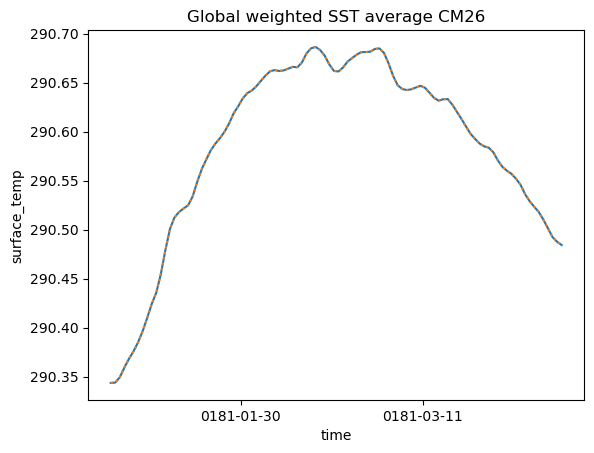

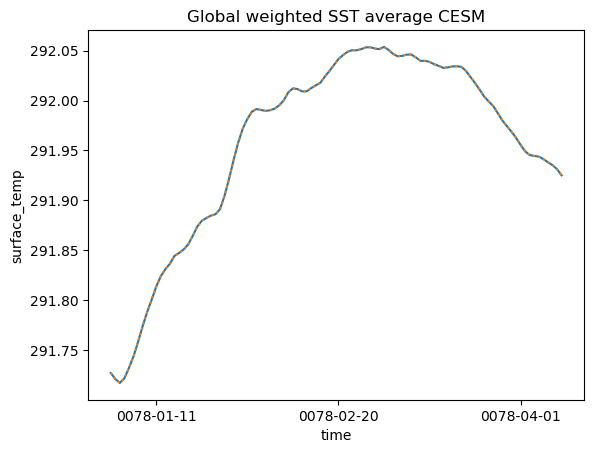

In [13]:
roi = dict(time=slice(0,100))

for model in ds_coarse_dict.keys():
    ds_raw_sample = ds_dict[model].isel(**roi)
    ds_coarse_sample = ds_coarse_dict[model].isel(**roi)

    def w_mean_plot(ds, label, ls):
        da = ds['surface_temp']
        da.weighted(da.area_t).mean(['xt_ocean', 'yt_ocean']).plot(label=label, ls=ls)
    
    plt.figure()
    w_mean_plot(ds_raw_sample, 'fine', '-')
    w_mean_plot(ds_coarse_sample, 'coarse', ':')
    plt.title(f'Global weighted SST average {model}')

#### Are eddies visually eliminated?

This is just a visual check for now.

<Figure size 640x480 with 0 Axes>

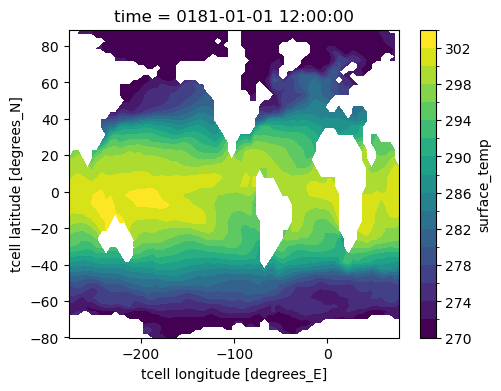

<Figure size 640x480 with 0 Axes>

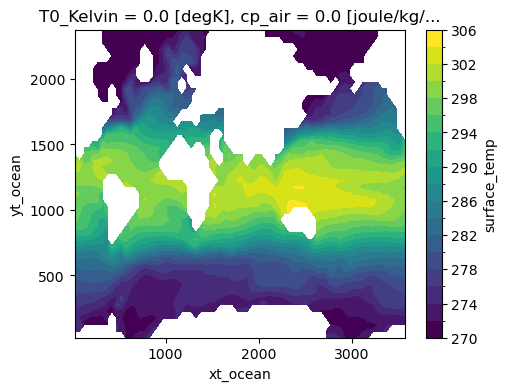

In [15]:
for model in ds_coarse_dict.keys():
    ds_coarse = ds_coarse_dict[model].isel(**roi)

    plt.figure()
    ds_coarse.isel(time=0).surface_temp.plot.contourf(levels=21, size=4)

### Save out the Coarsened Data

In [17]:
for model, ds_save in ds_coarse_dict.items():
    print(f"Saving coarse dataset for {model} ({ds_save.nbytes/1e9} GB)")
    ds_save.to_zarr(params['paths'][model]['coarse'])

Saving coarse dataset for CM26 (2.499607992 GB)
Saving coarse dataset for CESM (0.242452352 GB)


<xarray.Dataset>
Dimensions:       (yt_ocean: 54, xt_ocean: 72, time: 7305)
Coordinates:
    area_t        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(54, 72), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(54, 72), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(54, 72), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(54, 72), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(54, 72), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 dask.array<chunksize=(54, 72), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 dask.array<chunksize=(54, 72), meta=np.ndarray>
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
    wet           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(54, 72), meta=np.ndarray>
  * xt_ocean      (xt_ocean) float64 -277.5 -272.5 -267.5 ... 67.5 72.5 77.5
  * yt_ocean      (yt_ocean) float64 -80.07 -77.96 -75.85 ... 84.72 86.83 88.94
Data variables:
    q_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    slp           (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(3, 54, 72), meta=np.ndarray>

<xarray.Dataset>
Dimensions:             (yt_ocean: 48, xt_ocean: 72, time: 730)
Coordinates: (12/42)
    ANGLET              (yt_ocean, xt_ocean) float64 dask.array<chunksize=(48, 72), meta=np.ndarray>
    DXT                 (yt_ocean, xt_ocean) float64 dask.array<chunksize=(48, 72), meta=np.ndarray>
    DYT                 (yt_ocean, xt_ocean) float64 dask.array<chunksize=(48, 72), meta=np.ndarray>
    HT                  (yt_ocean, xt_ocean) float64 dask.array<chunksize=(48, 72), meta=np.ndarray>
    KMT                 (yt_ocean, xt_ocean) float64 dask.array<chunksize=(48, 72), meta=np.ndarray>
    REGION_MASK         (yt_ocean, xt_ocean) float64 dask.array<chunksize=(48, 72), meta=np.ndarray>
    ...                  ...
    sound               float64 ...
    stefan_boltzmann    float64 ...
  * time                (time) object 0078-01-01 00:00:00 ... 0079-12-31 00:0...
    vonkar              float64 ...
  * xt_ocean            (xt_ocean) float64 25.0 75.0 ... 3.525e+03 3.575e+03
  * yt_ocean            (yt_ocean) float64 25.0 75.0 ... 2.325e+03 2.375e+03
Data variables:
    TS                  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    U10                 (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    q_ref               (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    slp                 (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    surface_temp        (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    t_ref               (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    u_ocean             (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    u_ref               (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    u_relative          (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    v_ocean             (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    v_ref               (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>
    v_relative          (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 48, 72), meta=np.ndarray>

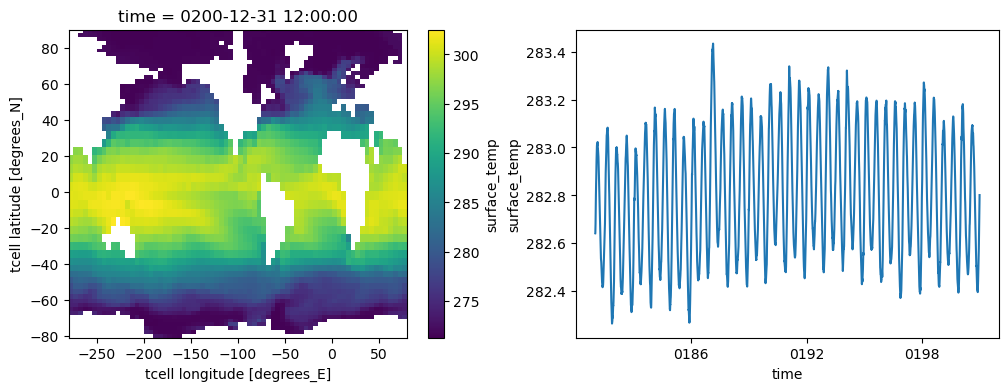

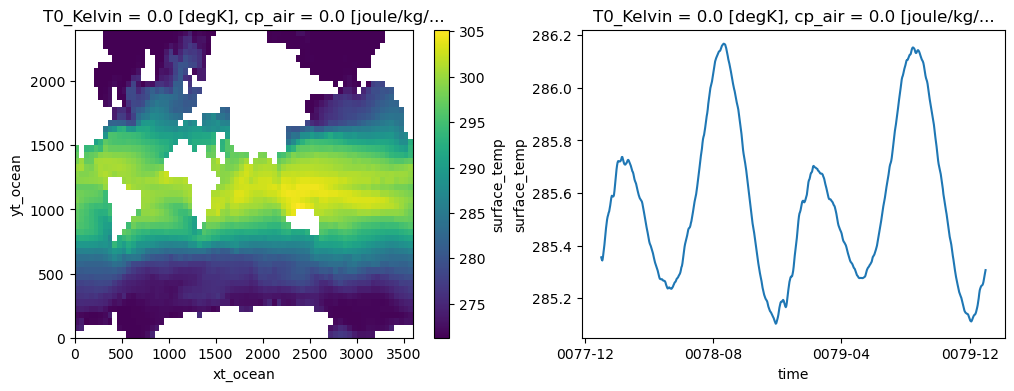

In [18]:
# Check the outputs quickly
for model in ds_coarse_dict.keys():
    ds_reloaded_coarse = open_zarr(params['paths'][model]['coarse'])
    display(ds_reloaded_coarse)
    plt.figure(figsize=[12,4])
    plt.subplot(1,2,1)
    ds_reloaded_coarse.isel(time=-1)['surface_temp'].plot()
    plt.subplot(1,2,2)
    ds_reloaded_coarse.surface_temp.mean(['xt_ocean', 'yt_ocean']).plot()

## Filtered input fields

In [29]:
ds_dict['CESM']

<xarray.Dataset>
Dimensions:             (yt_ocean: 2400, xt_ocean: 3600, time: 730)
Coordinates: (12/42)
    ANGLET              (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HT                  (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMT                 (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    REGION_MASK         (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    sea_ice_salinity    float64 ...
    sflux_factor        float64 ...
    sound               float64 ...
    stefan_boltzmann    float64 ...
  * time                (time) object 0078-01-01 00:00:00 ... 0079-12-31 00:0...
    vonkar              float64 ...
Data variables:
    slp                 (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    q_ref               (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    surface_temp        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    t_ref               (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    TS                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    U10                 (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    u_ref               (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    v_ref               (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    u_ocean             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    u_relative          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    v_ocean             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    v_relative          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [54]:
filter_vars = ['u_relative', 'v_relative', 'surface_temp', 't_ref', 'q_ref', 'slp', 'u_ocean', 'v_ocean', 'u_ref', 'v_ref']

ds_filtered_dict = {}

for model in ds_dict.keys():
    print(f"Filtering {model}")
    ds_raw = ds_dict[model][filter_vars]
    
    ds_filtered = filter_inputs_dataset(
        ds_raw, 
        ['yt_ocean', 'xt_ocean'], 
        params['filter_scale'], 
        filter_type=params['filter_type'],
    )
    
    # add the filtered variables to the original dataset
    for var in filter_vars:
        ds_raw[var+'_filtered'] = ds_filtered[var]
    
    # also rebuild a second relative wind from only ocean filtered velocities
    ds_raw['u_relative_filtered_ocean_only'] = ds_raw['u_ref'] - ds_raw['u_ocean_filtered']
    ds_raw['v_relative_filtered_ocean_only'] = ds_raw['v_ref'] - ds_raw['v_ocean_filtered']

    ds_raw['u_relative_filtered_atmos_only'] = ds_raw['u_ref_filtered'] - ds_raw['u_ocean']
    ds_raw['v_relative_filtered_atmos_only'] = ds_raw['v_ref_filtered'] - ds_raw['v_ocean']

    ds_filtered_dict[model] = ds_raw
    display(ds_filtered_dict[model])

Filtering CM26


<xarray.Dataset>
Dimensions:                         (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
    area_t                          (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt                             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt                             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t                        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t                        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht                              (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt                             (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time                            (time) object 0181-01-01 12:00:00 ... 020...
    wet                             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean                        (xt_ocean) float64 -279.9 -279.8 ... 79.95
  * yt_ocean                        (yt_ocean) float64 -81.11 -81.07 ... 89.98
Data variables: (12/24)
    u_relative                      (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative                      (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp                    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref                           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref                           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    slp                             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    ...                              ...
    u_ref_filtered                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref_filtered                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_filtered_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_filtered_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_filtered_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_filtered_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

Filtering CESM


<xarray.Dataset>
Dimensions:                         (time: 730, yt_ocean: 2400, xt_ocean: 3600)
Coordinates: (12/42)
    ANGLET                          (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HT                              (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMT                             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    REGION_MASK                     (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                              ...
    sea_ice_salinity                float64 ...
    sflux_factor                    float64 ...
    sound                           float64 ...
    stefan_boltzmann                float64 ...
  * time                            (time) object 0078-01-01 00:00:00 ... 007...
    vonkar                          float64 ...
Data variables: (12/24)
    u_relative                      (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    v_relative                      (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    surface_temp                    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    t_ref                           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    q_ref                           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    slp                             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    ...                              ...
    u_ref_filtered                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    v_ref_filtered                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    u_relative_filtered_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    v_relative_filtered_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    u_relative_filtered_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    v_relative_filtered_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

### Some sanity checks with the data before large batch save

#### Check that the nanmask is uniform across variables

All variables should have the same missing values. Previous versions had different nans for vel and tracers.
See [here](https://github.com/ocean-transport/scale-aware-air-sea/issues/46) for details.

CM26


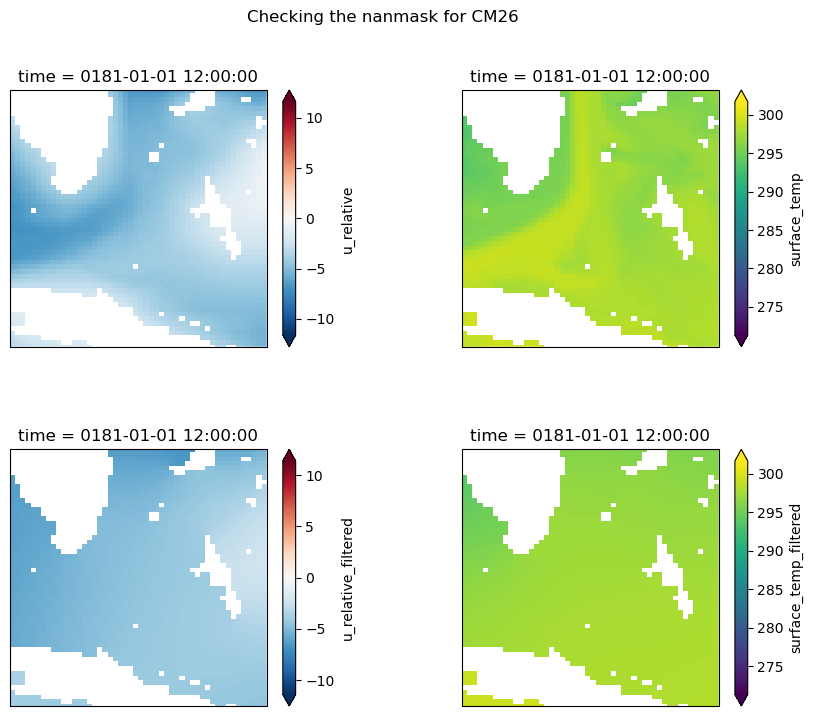

CESM


Task exception was never retrieved
future: <Task finished name='Task-23934' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:2189> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py", line 2198, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-23955' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:2189> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py", line 2198, in wait
    raise AllExit()
distributed.client.AllExit


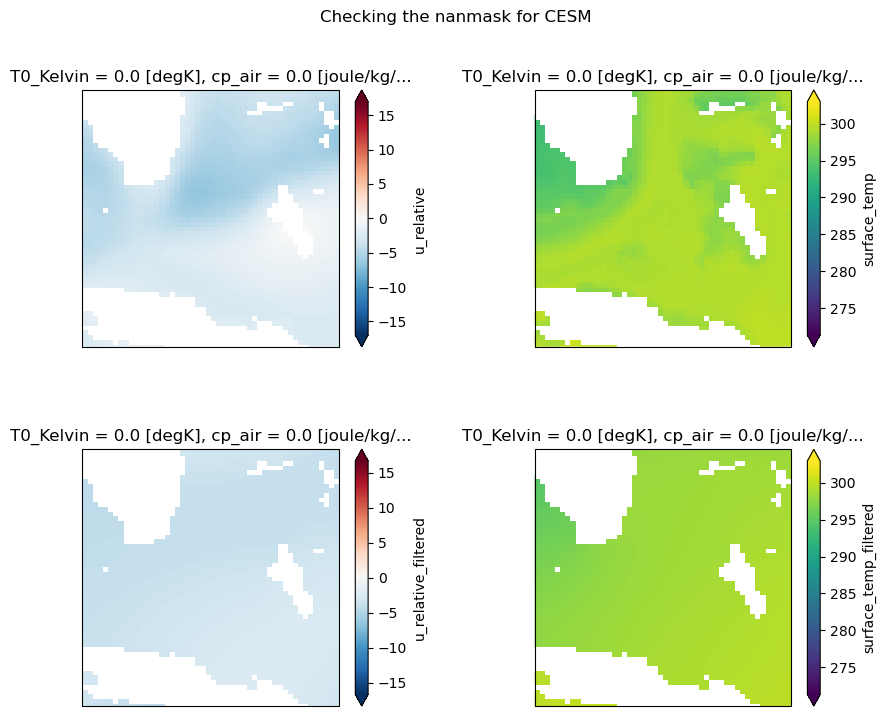

In [59]:
plot_vars=['u_relative', 'surface_temp', 'u_relative_filtered', 'surface_temp_filtered']

import cartopy.crs as ccrs
proj = ccrs.PlateCarree()

for model in ds_filtered_dict.keys():
    print(model)
    test_ds = ds_filtered_dict[model].isel(time=0).load() # this is alot more than we need, but serves as a test for all filtered variables

    fig, axarr = plt.subplots(ncols=2, nrows=2,figsize=[10,8], subplot_kw={'projection':proj})
    for i, (var, ax) in enumerate(zip(plot_vars, axarr.flat)):
        test_ds[var].plot(ax=ax, x='geolon_t', y='geolat_t', robust=True, transform=proj)
        ax.set_extent([-82, -77, 22, 27]) # Around Florida we can check this well with a lot of small islands.
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.suptitle(f"Checking the nanmask for {model}")
    plt.show()

### Save out the Filtered Data

In [61]:
# prune dataset for saving
keep_vars = [
    'slp_filtered', 'surface_temp_filtered',
    'u_relative_filtered','v_relative_filtered',
    'u_relative_filtered_ocean_only','v_relative_filtered_ocean_only',
    'u_relative_filtered_atmos_only','v_relative_filtered_atmos_only',
    't_ref_filtered', 'q_ref_filtered'
]
for model, ds_save in ds_filtered_dict.items():
# for now only reprocess the new dataset
# for model, ds_save in {k:v for k,v in ds_filtered_dict.items() if k == 'CESM'}.items():
    ds_save = ds_save[keep_vars]
    print(f"Saving filtered dataset for {model} ({ds_save.nbytes/1e12} TB)")
    ds_save.to_zarr(params['paths'][model]['filter'])

Saving filtered dataset for CESM (0.25291013408 TB)


### Double Check the written data

CM26


<xarray.Dataset>
Dimensions:                         (yt_ocean: 2700, xt_ocean: 3600, time: 7305)
Coordinates:
    area_t                          (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt                             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt                             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t                        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t                        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht                              (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt                             (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time                            (time) object 0181-01-01 12:00:00 ... 020...
    wet                             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean                        (xt_ocean) float64 -279.9 -279.8 ... 79.95
  * yt_ocean                        (yt_ocean) float64 -81.11 -81.07 ... 89.98
Data variables:
    q_ref_filtered                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    slp_filtered                    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp_filtered           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref_filtered                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_filtered             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_filtered_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative_filtered_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_filtered             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_filtered_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative_filtered_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

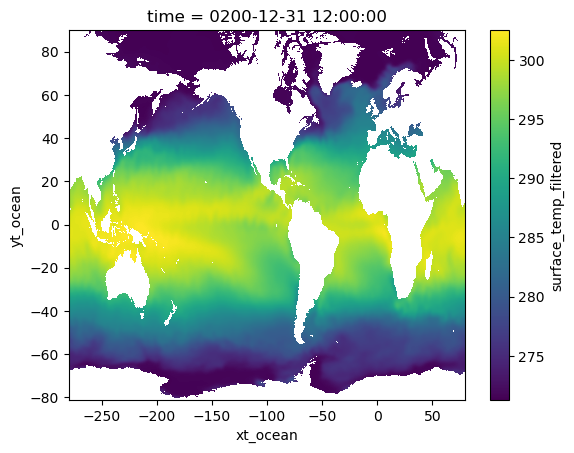

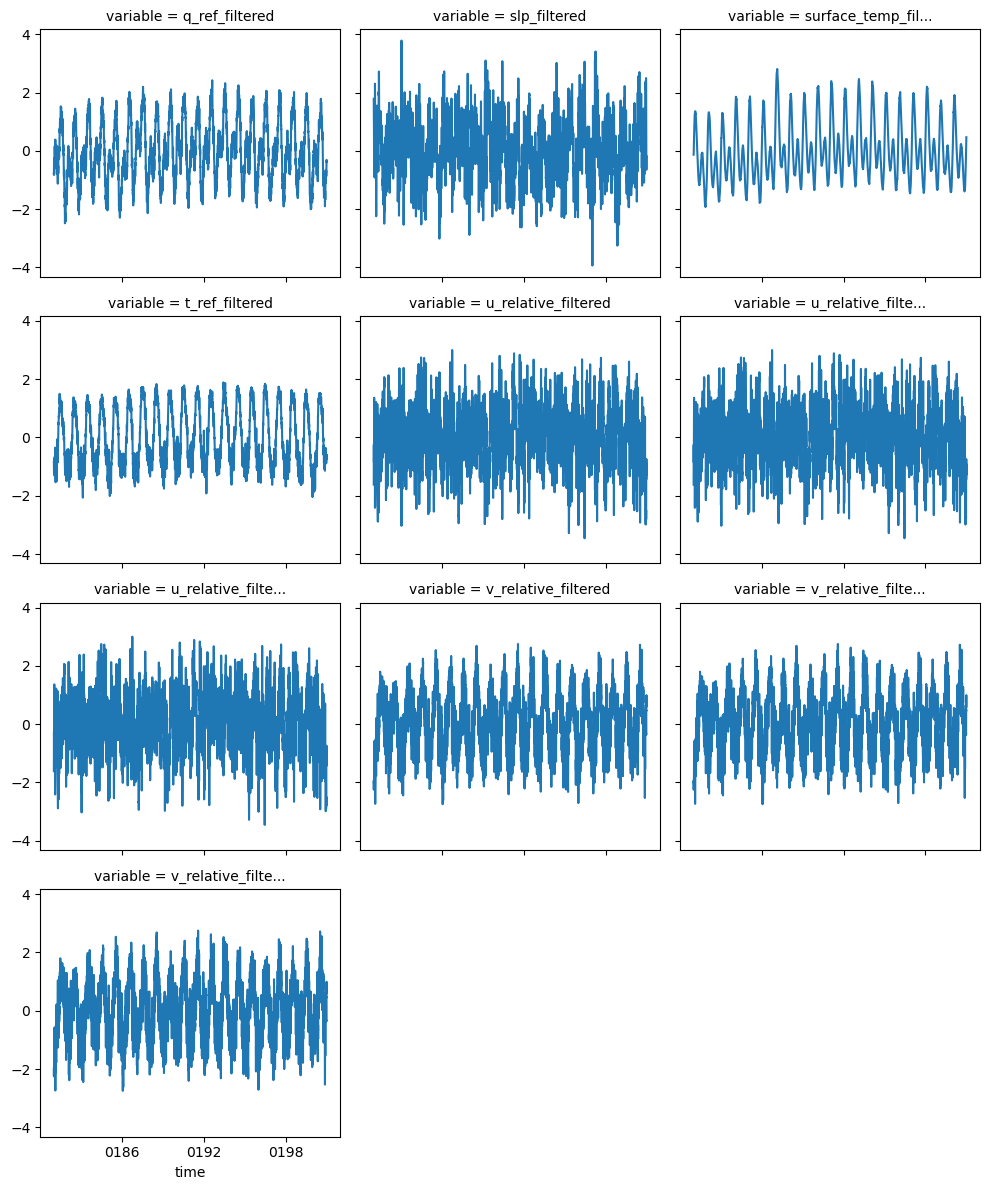

CESM


<xarray.Dataset>
Dimensions:                         (yt_ocean: 2400, xt_ocean: 3600, time: 730)
Coordinates: (12/42)
    ANGLET                          (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HT                              (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMT                             (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    REGION_MASK                     (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                              ...
    sound                           float64 ...
    stefan_boltzmann                float64 ...
  * time                            (time) object 0078-01-01 00:00:00 ... 007...
    vonkar                          float64 ...
  * xt_ocean                        (xt_ocean) float64 0.5 1.5 ... 3.6e+03
  * yt_ocean                        (yt_ocean) float64 0.5 1.5 ... 2.4e+03
Data variables:
    q_ref_filtered                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    slp_filtered                    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    surface_temp_filtered           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    t_ref_filtered                  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    u_relative_filtered             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    u_relative_filtered_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    u_relative_filtered_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    v_relative_filtered             (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    v_relative_filtered_atmos_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    v_relative_filtered_ocean_only  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

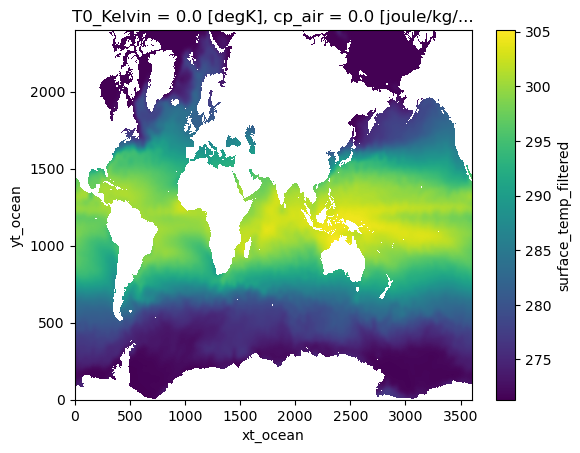

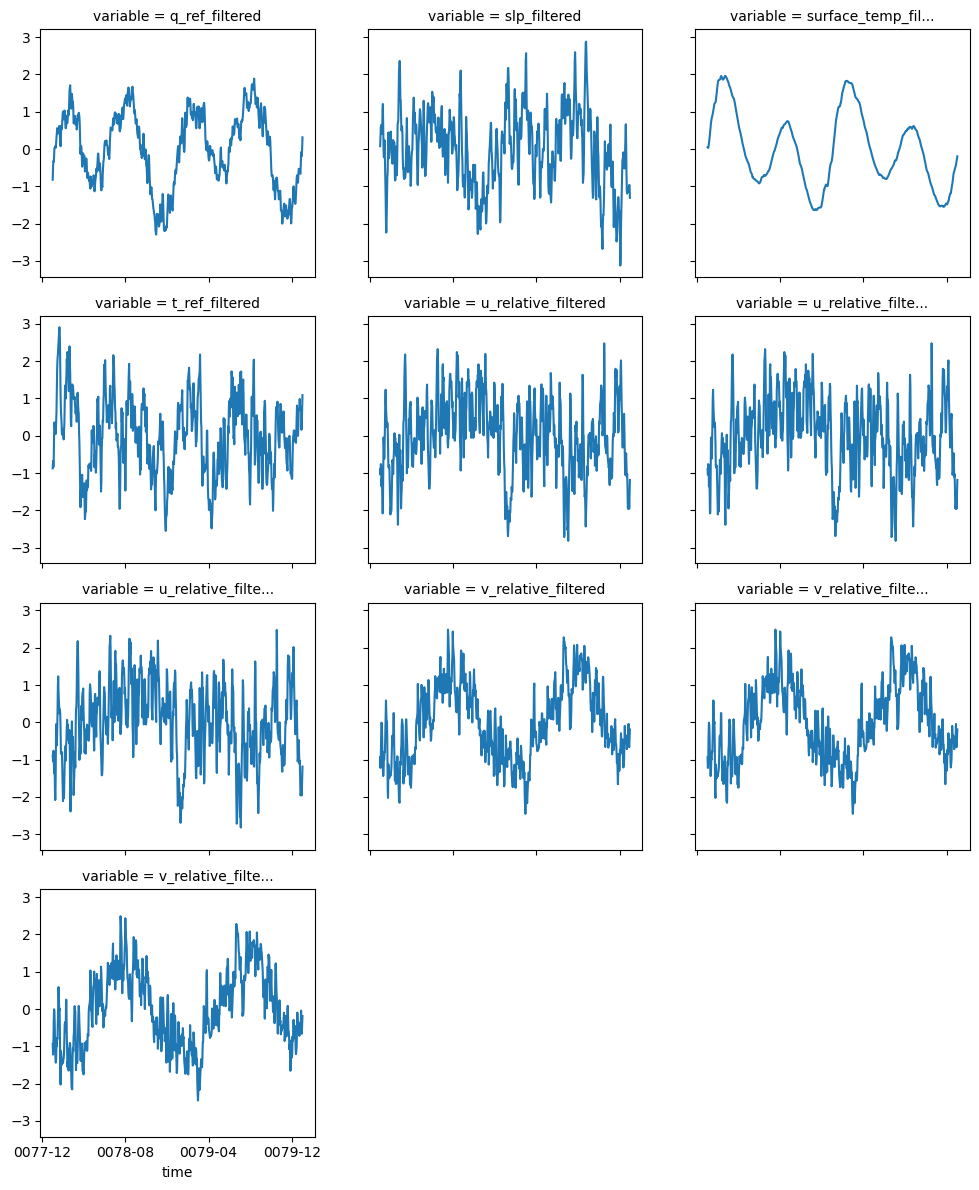

In [5]:
for model in models:
    print(model)
    ds_reloaded_filter = open_zarr(params['paths'][model]['filter'])
    display(ds_reloaded_filter)

    ds_reloaded_filter.surface_temp_filtered.isel(time=-1).plot()

    da_reloaded_filter = ds_reloaded_filter.to_array()
    timeseries = da_reloaded_filter.mean(['xt_ocean','yt_ocean']).load()
    timeseries_normalized = (timeseries - timeseries.mean('time')) / timeseries.std('time')
    timeseries_normalized.plot(col='variable', col_wrap=3)
    plt.show()

In [6]:
cluster.shutdown()